# Mounting to google drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading cleaned dataset

In [ ]:
import pandas as pd
csv_path = '/content/drive/MyDrive/BanglaSentiment/Bangla/cleaned.csv'
df = pd.read_csv(csv_path)

In [ ]:
df.head(10)

,review,category,rating,tag
0,সেলারকে যখনই এসএমএস দিয়েছি সাথে সাথে রেসপন্স ...,Electronics,5,positive
1,পন্যের মান দাম হিসেবে বেশ ভালো সাধারণত দাম ১ ট...,Clothing,5,positive
2,বিসমিল্লাহির রাহমানির রাহিম দারাজ ভাইকে ধন্যবা...,Clothing,5,positive
3,কাপরের মান ভাল না সেলাইয়েরও তেমন ফিনিশিং নাই আ...,Clothing,3,negative
4,ধন্যবাদ সেলার কে ঠিক যেমনটি চেয়েছিলাম তেমনটি ...,Clothing,5,positive
5,ভাল মানের এবং ভাল প্যাকিং আমি এই দামে সন্তুষ্ট...,Clothing,4,positive
6,প্রথমে ধন্যবাদ জানাই সেলার ভাইকে এতো সুন্দর এক...,Clothing,5,positive
7,কোয়ালিটি মোটামুটি ভালো আপনারা চাইলে নিতে পারে...,Clothing,4,positive
8,অসাধারণ 🤩 এই প্রজাজ এ বেষ্ট টি-শার্ট ধন্যবাদ ব...,Clothing,5,positive
9,খুবই সুন্দর একটি প্রোডাক্ট আমি এই প্রথম দারাজে...,Clothing,5,positive


In [ ]:
def to_sentiment(tag):
  if tag == "negative":
    return 0
  elif tag == "neutral":
    return 1
  else:
    return 2

df['tag'] = df.tag.apply(to_sentiment)

In [ ]:
df.sample()

,review,category,rating,tag
598,নির্দিষ্ট সময় থেকো তিন চার দিন দেরি,Clothing,3,0


# Importing bert_model

In [ ]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers

Sat Jun 17 16:25:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.30.2



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model_name = 'sagorsarker/bangla-bert-base'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-ber

# Tokenization

In [ ]:
!pip install bltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bltk: filename=bltk-1.2-py3-none-any.whl size=17432524 sha256=7da43dc4e194d1d6db4a0886dd268a6712dad657422d304a17e7fbe7b51c2c96
  Stored in directory: /root/.cache/pip/wheels/52/7d/57/4806e1ef5d1ad1491ce0ac43aaa0377293efbc9a81d5b7e6c8
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=3224df20891d11aad9dc7c24de28248f52c78b5ab17e10574f347cc6866da158
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built bltk sklearn


In [ ]:
from bltk.langtools import remove_stopwords

In [ ]:
sample_txt = "আমি জানি আমার এই লেখাটির জন্য আমাকে অনেক গালমন্দ শুনতে হবে, তারপরেও লিখছি। " \
       "লিখে খুব কাজ হয় সে রকম উদাহরণ আমার হাতে খুব বেশী নেই কিন্তু অন্তত নিজের ভেতরের ক্ষোভটুকু বের করা " \
       "যায় সেটাই আমার জন্যে অনেক।"

tokens = tokenizer.tokenize(sample_txt)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
tokens = remove_stopwords(tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Len of words: {len(tokens)}")
print(f"After soft elimination: {(tokens)}")
print(f'Token IDs: {token_ids}')

 Sentence: আমি জানি আমার এই লেখাটির জন্য আমাকে অনেক গালমন্দ শুনতে হবে, তারপরেও লিখছি। লিখে খুব কাজ হয় সে রকম উদাহরণ আমার হাতে খুব বেশী নেই কিন্তু অন্তত নিজের ভেতরের ক্ষোভটুকু বের করা যায় সেটাই আমার জন্যে অনেক।
   Tokens: ['আমি', 'জানি', 'আমার', 'এই', 'লেখাটি', '##র', 'জন', '##য', 'আমাকে', 'অনেক', 'গাল', '##মন', '##দ', 'শন', '##তে', 'হবে', ',', 'তারপরেও', 'লিখছি', '।', 'লিখে', 'খ', '##ব', 'কাজ', 'হয', 'সে', 'রকম', 'উদাহরণ', 'আমার', 'হাতে', 'খ', '##ব', 'বেশী', 'নেই', 'কিনত', 'অন', '##তত', 'নিজের', 'ভেতরের', 'কষে', '##াভ', '##টক', 'বের', 'করা', 'যা', '##য', 'সেটাই', 'আমার', 'জন', '##যে', 'অনেক', '।']
Len of words: 39
After soft elimination: ['জানি', 'লেখাটি', '##র', 'জন', '##য', 'অনেক', 'গাল', '##মন', '##দ', 'শন', '##তে', 'তারপরেও', 'লিখছি', 'লিখে', 'খ', '##ব', 'কাজ', 'হয', 'রকম', 'উদাহরণ', 'হাতে', 'খ', '##ব', 'বেশী', 'কিনত', 'অন', '##তত', 'ভেতরের', 'কষে', '##াভ', '##টক', 'বের', 'করা', 'যা', '##য', 'সেটাই', 'জন', '##যে', 'অনেক']
Token IDs: [3862, 17076, 2046, 2181, 9294, 2115, 15095, 1095

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2169,  3862,  2211,  2045, 17076,  2046,  2181,  9294,  2988,
         2115, 15095, 10951,  5718, 12123,  2200,  2055,  1011, 22068, 25692,
         1014,  4905,  5356,  4282,  2114, 33668,  2118,  2458,  3253,  2211,
         2317,   102])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'আমি',
 'জানি',
 'আমার',
 'এই',
 'লেখাটি',
 '##র',
 'জন',
 '##য',
 'আমাকে',
 'অনেক',
 'গাল',
 '##মন',
 '##দ',
 'শন',
 '##তে',
 'হবে',
 ',',
 'তারপরেও',
 'লিখছি',
 '।',
 'লিখে',
 'খ',
 '##ব',
 'কাজ',
 'হয',
 'সে',
 'রকম',
 'উদাহরণ',
 'আমার',
 'হাতে',
 '[SEP]']

# Choosing Max Sequence Length

In [ ]:
df.dropna(axis=0, how="any", inplace=True)

In [ ]:
token_lens = []

for txt in df.review:
  # print(txt)
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-20-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


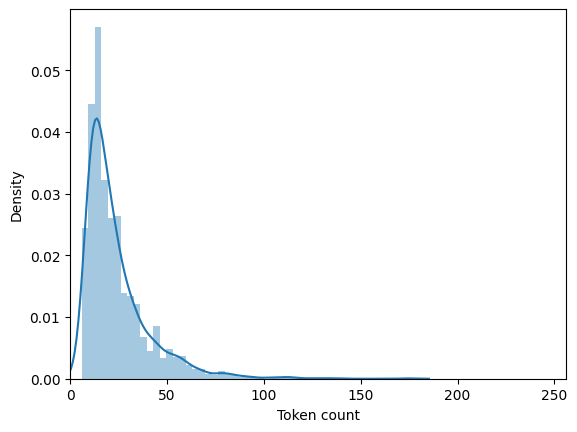

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 120

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1347, 4), (289, 4), (289, 4))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.tag.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_data_loader

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 120])
torch.Size([32, 120])
torch.Size([32])


In [ ]:
PRE_TRAINED_MODEL_NAME = 'sagorsarker/bangla-bert-base'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.9217, -0.4113,  1.0848,  ..., -0.4675, -0.7322, -0.7537],
         [-0.6370,  1.0776, -1.6399,  ...,  0.9471, -1.5186,  1.9381],
         [ 0.6479,  0.2001,  1.0746,  ..., -0.2947, -1.2484,  0.2927],
         ...,
         [ 0.4310,  0.3434,  0.6918,  ...,  0.2838, -0.5042,  0.5974],
         [-0.6271, -0.6998,  0.4923,  ..., -0.3694, -0.9958, -0.4018],
         [ 0.2757,  0.0283,  0.0903,  ...,  0.1336, -0.1785,  0.2919]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.2509, -0.9002, -0.4772, -0.2779, -0.2228, -0.8908,  0.9953, -0.0070,
         -0.1624,  0.3038, -0.3305, -0.0380,  0.1638, -0.1702,  0.1754,  0.9624,
         -0.2156,  0.0753, -0.3373,  0.1389, -0.8524,  0.4350, -0.2480, -0.9959,
         -0.6065, -0.2460,  0.9989,  0.1907, -0.9979, -0.7316, -0.1609,  0.0364,
          0.9928, -0.1956,  0.2292,  0.4182, -0.2375, -0.1058,  0.0372,  0.8958,
         -0.3095,  0.9672,  0.03

In [ ]:
pooled_output = outputs['pooler_output']
last_hidden_state = outputs['last_hidden_state']

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 120])
torch.Size([32, 120])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3074, 0.3717, 0.3209],
        [0.4144, 0.2315, 0.3540],
        [0.4828, 0.2498, 0.2673],
        [0.2879, 0.4971, 0.2150],
        [0.2202, 0.4035, 0.3763],
        [0.3030, 0.2000, 0.4970],
        [0.2222, 0.2967, 0.4811],
        [0.5238, 0.2902, 0.1860],
        [0.2322, 0.3459, 0.4219],
        [0.2115, 0.3290, 0.4595],
        [0.3737, 0.2224, 0.4039],
        [0.3560, 0.3705, 0.2735],
        [0.2982, 0.2609, 0.4409],
        [0.3154, 0.2738, 0.4108],
        [0.3544, 0.4084, 0.2373],
        [0.2492, 0.3676, 0.3832],
        [0.2359, 0.4143, 0.3498],
        [0.3327, 0.3242, 0.3431],
        [0.2481, 0.3859, 0.3661],
        [0.3569, 0.2995, 0.3436],
        [0.2111, 0.5233, 0.2657],
        [0.2887, 0.3111, 0.4002],
        [0.3516, 0.3462, 0.3021],
        [0.3622, 0.3349, 0.3029],
        [0.2715, 0.3730, 0.3555],
        [0.2833, 0.3391, 0.3776],
        [0.3163, 0.3647, 0.3190],
        [0.3461, 0.3284, 0.3256],
        [0.2184, 0.4771, 0.3045],
        [0.391

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.5722093928691953 accuracy 0.7668893838158871


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.3600188158452511 accuracy 0.8650519031141869

Epoch 2/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.19077757642019627 accuracy 0.9398663697104677


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.2729396665468812 accuracy 0.9100346020761246

Epoch 3/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.05248137448946837 accuracy 0.9814402375649591


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.29120782350655644 accuracy 0.9100346020761246

CPU times: user 1min 6s, sys: 4.35 s, total: 1min 11s
Wall time: 1min 23s


In [ ]:
x = np.array([float(tensor) for tensor in history['train_acc']])
y = np.array([float(tensor) for tensor in history['val_acc']])

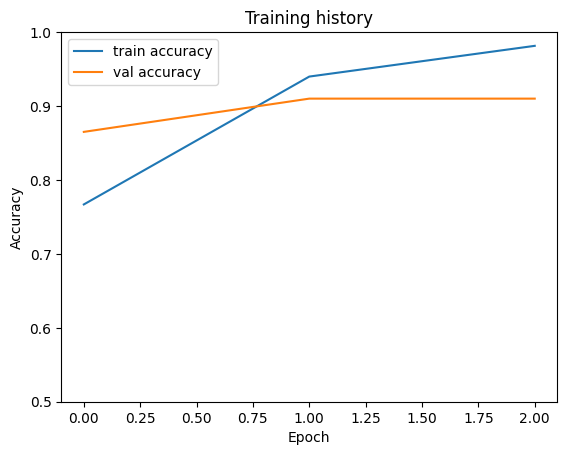

In [ ]:
plt.plot(x, label='train accuracy')
plt.plot(y, label='val accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1]);
plt.show()

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.9100346020761246

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.93      0.90        94
     neutral       0.91      0.94      0.93        72
    positive       0.95      0.88      0.91       123

    accuracy                           0.91       289
   macro avg       0.91      0.92      0.91       289
weighted avg       0.91      0.91      0.91       289



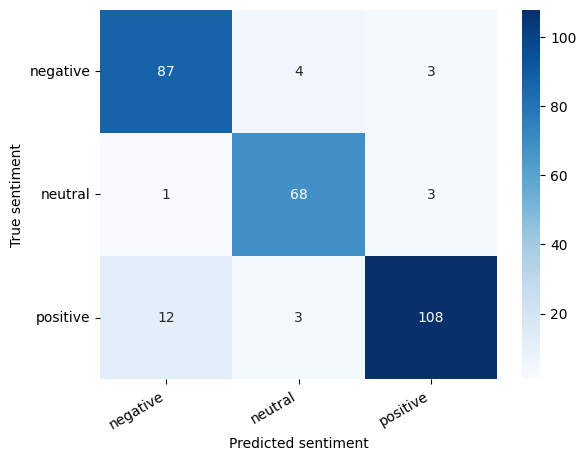

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 4

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

পিক এ যেমন দেখানো তেমনি ছিলো  প্যাকিজিং ও ভালো ছিলো তবে ভাবছিলাম পিক এ
দেখা বক্স টাও থাকবে কিন্তু হতাশ 🤪 আর এক পাসের ডাট (ফ্রেম) একটু বাকা
ছিলো এখন এটা আগে থেকেই নাকি ডেলিভারির সময় চাপে এমন হয়েছিলো বুঝলাম না
তবে তা ফিক্স করা গেছে  অভার অল দাম অনুযায়ী ভালো ছিলো

True sentiment: positive


In [ ]:
for idx in range(10):
  review_text = y_review_texts[idx]
  true_sentiment = y_test[idx]
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
  })
  print("\n".join(wrap(review_text)))
  print(f'True sentiment: {class_names[true_sentiment]}')
  print()

আপনারা চাইলে নিতে পারেন 🥰🥰
True sentiment: positive

ব্লুটুথ হেডফোনটা কথা বলার জন্য সঠিক গান শোনার জন্য না  🥰🥰🥰মিউজিক
সিস্টেম খুব হালকা  খালি একটাই সমস্যা আমার কানে হচ্ছে না আরেকটু ছোট
সাইজ লাগতো  🥰
True sentiment: neutral

মোটামুটি কাপড় আরও ভালো কাপড় আশা করেছিলাম
True sentiment: neutral

খুবই বাজে ও নিম্নমানের এখন রিটার্ন করলে টাকা ফেরত পাবো কবে?
True sentiment: negative

পিক এ যেমন দেখানো তেমনি ছিলো  প্যাকিজিং ও ভালো ছিলো তবে ভাবছিলাম পিক এ
দেখা বক্স টাও থাকবে কিন্তু হতাশ 🤪 আর এক পাসের ডাট (ফ্রেম) একটু বাকা
ছিলো এখন এটা আগে থেকেই নাকি ডেলিভারির সময় চাপে এমন হয়েছিলো বুঝলাম না
তবে তা ফিক্স করা গেছে  অভার অল দাম অনুযায়ী ভালো ছিলো
True sentiment: positive

সাউন্ড কোয়ালিটি ভালো আছে
True sentiment: positive

আংটিটা  আমার হাতের সাইজে হয় নাই হাতে পড়ে হাতেহয় না  কেটে ফেলেছি
কিভাবে রিটার্ন দেয় তাও আমি জানিনা 😔😔😔😔😔
True sentiment: neutral

অসংখ্য ধন্যবাদ দারাজ কে
True sentiment: positive

খুব ভালো টি-শার্ট গলাতবে দাম তা আর একটু কম হলে ভালো হতোতা ছাড়া পিকচার
যা দেখানো মতোই প্রোডাক্ট পাইছ

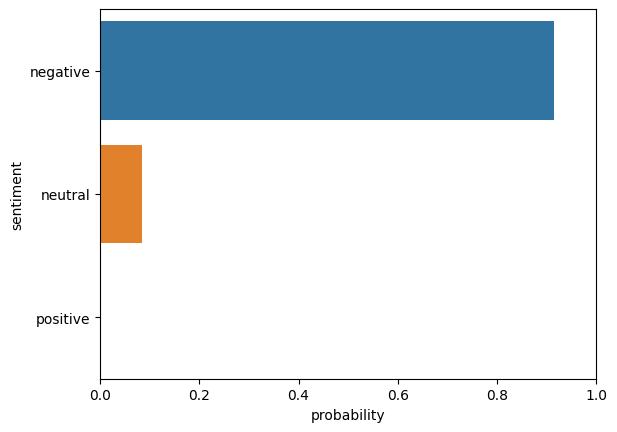

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
def check_model(review_text):
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
text1 = "খুব একটা যে ভালো তা না তবে মোটামুটি চলে।"
text2 = "অনেক ভালো সবকিছু ঠিক আছে"
text3 = "কোয়ালিটি ভাল লাগেনি"
text4 = "খুব বাজে প্রডাক্ট"

In [ ]:
check_model(text1)
check_model(text2)
check_model(text3)
check_model(text4)

Review text: খুব একটা যে ভালো তা না তবে মোটামুটি চলে।
Sentiment  : neutral
Review text: অনেক ভালো সবকিছু ঠিক আছে
Sentiment  : positive
Review text: কোয়ালিটি ভাল লাগেনি
Sentiment  : negative
Review text: খুব বাজে প্রডাক্ট
Sentiment  : negative


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: যারা একটু বেশি সাউন্ড আশা করেন তারা নিয়েন না
Sentiment  : negative


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/BanglaSentiment/Bangla/model.pth')